In [2]:
from resources.AIRMODE.load_helpers import *
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sbn

## Problem statement

### Resources
* Pre-existing IO simulations from a computational model
$$ D^{sim}=\{(\theta_i, d_i), y_i\}_{i=1}^{N} $$
* A surrogate or high-fidelity simulator (for incremental sampling strategy)

$$y = M(x;\theta) $$

* Empirical data from a real system output responses
$$ D^{emp}=\{y_i\}_{i=1}^{N} $$
* Possibly conditioned by some known quantity (design/building type) $x$
$$ D^{emp}=\{x_k ; \{ y_{j,k} \}_{j=1}^N \}_{i=1}^{n_x} $$

### Objective

- Use efficiently existing $D^{sim}$ to identify a plausible set (or a distribution for) the uncertain parameters $\theta$



In [3]:
# ------------------------------------------------
# 1.1 LOAD AND PARTITION INTO MODEL INPUTS/OUTPUTS
# ------------------------------------------------
data_all = pd.read_pickle('resources/ENERGY_PLUS/energy_plus_simulations.pkl')
inputs = [ "num_persons", "u_roof", "u_wall", "u_ground", 'rh_out_level_hourxdayxzone'
           "schedul_temps", "u_wind", "S_V", "wwr",
           'rectangularity', 'perimeter', 'height' ]
# outputs = ["annual_demand_kwh_m2_year"] + [f"{m}_demand_kwh/mq" for m in range(1, 13)] # all ouputs
outputs = ["annual_demand_kwh_m2_year"] + [f"{m}_demand_kwh/mq" for m in range(1, 5)]


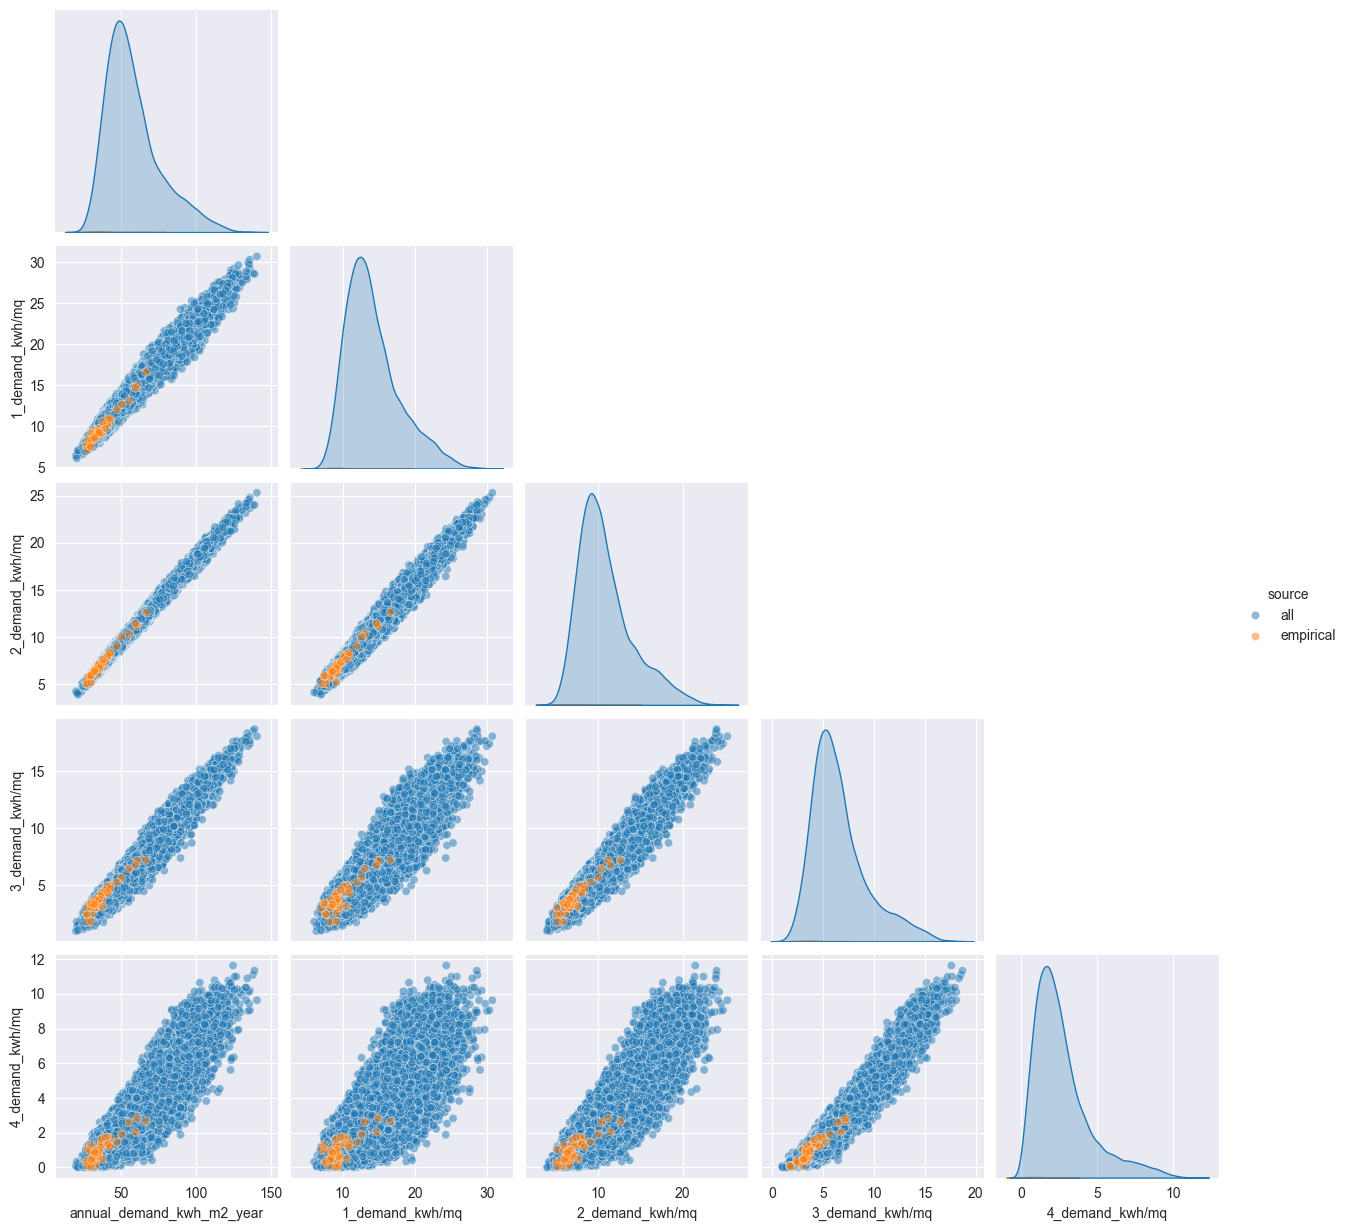

In [10]:
# Define building_type
building_type = (data_all['u_ground'] < 0.5) & \
                (data_all['u_roof'] < 0.5) & \
                (data_all['u_wall'] < 0.5)

# Subset the first 40 rows of this type
Y_emp = data_all[building_type].iloc[:40, :][outputs]

# Add a 'source' column to distinguish datasets
data_all_labeled = data_all[outputs].copy()
data_all_labeled['source'] = 'all'

Y_emp_labeled = Y_emp.copy()
Y_emp_labeled['source'] = 'empirical'

# Combine
combined = pd.concat([data_all_labeled, Y_emp_labeled], axis=0)

# Pairplot with hue to distinguish
sbn.pairplot(combined, hue='source', corner=True, plot_kws={'alpha':0.5})


In [ ]:
data_all[inputs]

In [ ]:
import seaborn as sbn
sbn.pairplot(data_all[inputs])

In [ ]:
do_run_data_aug = False
if do_run_data_aug:
    # ------------------------------------------------
    # 1.2 AUGMENT DATA
    # ------------------------------------------------
    data_all = pd.DataFrame(data_all)  # ensure it's a DataFrame

    numeric_cols = data_all.select_dtypes(include=np.number).columns
    non_numeric_cols = data_all.columns.difference(numeric_cols)

    n_aug = 10       # number of perturbations per row
    perturb_std = 0.0000

    # Repeat original numeric data
    numeric_data = np.repeat(data_all[numeric_cols].values, n_aug + 1, axis=0)

    # Add noise to all but the original rows
    noise = np.random.normal(0, perturb_std, size=numeric_data.shape)
    for i in range(0, len(numeric_data), n_aug + 1):
        noise[i] = 0  # no noise for the original row
    numeric_data += noise

    # Repeat non-numeric data
    non_numeric_data = np.repeat(data_all[non_numeric_cols].values, n_aug + 1, axis=0)

    # Combine
    data_all = pd.DataFrame(   np.hstack([numeric_data, non_numeric_data]), columns=list(numeric_cols) + list(non_numeric_cols))

In [ ]:
# Full X and Y
X_all = data_all[inputs]
Y_all = data_all[outputs]


# ------------------------------------------------
# 2. DEFINE “BUILDING TYPE” USING GEOMETRY & MATERIALS
#    (these determine similarity between buildings)
# ------------------------------------------------
conditioning_params = [  "num_persons", "u_roof", "u_wall", "u_ground",
                         "u_wind" , "num_floors", "floor_area", "heated_area",
                         "rectangularity",  "perimeter", "height",  "S_V", "wwr", "city"]
X_build = data_all[conditioning_params]
X_build_enc = pd.get_dummies(X_build, columns=["city"])  # One-hot encode categorical parameters

# Standardize scales for distance computation
scaler = StandardScaler()
X_build_scaled = scaler.fit_transform(X_build_enc)

In [ ]:

# ------------------------------------------------
# 3. SELECT A REFERENCE BUILDING TYPE
#    (Here: use the first building; you can choose any index)
ref_index = 0
ref_vec = X_build_scaled[ref_index].reshape(1, -1)

# ------------------------------------------------
# 4. SELECT 10–100 MOST SIMILAR BUILDINGS USING KNN
# ------------------------------------------------
k = 500   # max number of empirical samples you want
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_build_scaled)
distances, indices = knn.kneighbors(ref_vec)
# Select between 10 and 100 similar buildings
n_empirical = 50   # ← set how many empirical points you want (10–100)
selected_idx = indices[0][:n_empirical]
data_similar = data_all.iloc[selected_idx]
# Model inputs/outputs limited to these similar buildings
X_target = data_similar[inputs]
Y_sim = data_similar[outputs]

# ------------------------------------------------
# 5. GENERATE EMPIRICAL DATA (simulation + noise)
# ------------------------------------------------
# Example: Y_sim is (n_rows, n_cols)
n_samples = 10      # number of perturbed samples per row
noise_scale = 0.0001
# Repeat each row n_samples times
Y_repeated = np.repeat(Y_sim, n_samples, axis=0)
# Generate random noise
noise = np.random.randn(*Y_repeated.shape) * noise_scale
# Apply noise
Y_emp = Y_repeated * (1 + noise)
# ------------------------------------------------
# Final objects:
#   - X_selected : model inputs for similar buildings
#   - Y_sim      : simulation outputs (true)
#   - Y_emp      : empirical noisy outputs
# ------------------------------------------------
Y_emp  = pd.DataFrame(Y_emp, columns=outputs)

In [ ]:
import numpy as np
Y_emp = Y_all[np.logical_and(Y_all['annual_demand_kwh_m2_year']>35 , Y_all['annual_demand_kwh_m2_year']<40)]
X_target = X_all[np.logical_and(Y_all['annual_demand_kwh_m2_year']>35 , Y_all['annual_demand_kwh_m2_year']<40)]


In [ ]:
# ------------------------------------------------
# 6.  RUN DATA-DRIVEN CALIBRATION METHOD
# ------------------------------------------------
X_selected, Y_selected , Y_emp_array= X_all.to_numpy(), Y_all.to_numpy(), Y_emp.to_numpy()

# fit standard scaler on the outputs responses
scaler = StandardScaler()
scaler.fit(Y_selected)

## - - - Union of simulated input outputs including new simulation
N_knn = 10
neigh = NearestNeighbors(n_neighbors=N_knn)
neigh.fit(scaler.transform(Y_selected))
_, knn_idx2 = neigh.kneighbors(scaler.transform(Y_emp_array))
theta_set_2 = np.vstack([X_selected[idx] for idx in knn_idx2])
Y_calibrated_knn_2  = np.vstack([Y_selected[idx] for idx in knn_idx2])
Y_calibrated_knn_pd = pd.DataFrame(Y_calibrated_knn_2, columns=outputs)



In [ ]:
# --- Plots  (OUTPUT EMP, OUT Calibrated vs OUT TARGET) --
plt.figure(figsize=(6,4))
namex, namey = 'annual_demand_kwh_m2_year', '5_demand_kwh/mq'
plt.scatter(Y_all[namex], Y_all[namey], c='b', label='sim DB')
plt.scatter(Y_calibrated_knn_pd[namex], Y_calibrated_knn_pd[namey], 5, alpha=0.6, c='g', label=f'{N_knn}-knn')
plt.scatter(Y_emp[namex], Y_emp[namey] , c ='r', alpha=0.6, label='emp')

plt.legend()
plt.title("Simulated vs Empirical Outputs")
plt.xlabel(namex)
plt.ylabel(namey)
plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_calibrated_knn_pd = pd.DataFrame(theta_set_2, columns=inputs)

n_vars = len(inputs)
fig, axes = plt.subplots(n_vars, 1, figsize=(8, 3*n_vars))

for i, var in enumerate(inputs):
    ax = axes[i]

    # Plot histograms
    sns.histplot(X_all[var], bins=15, color='b', alpha=0.3, kde=True, stat='density',  ax=ax, label='sim')
    sns.histplot(X_calibrated_knn_pd[var], bins=15, color='g', alpha=0.5, kde=True, stat='density',  ax=ax, label='calibrated (knn)')
    sns.histplot(X_target[var], bins=15, color='r', alpha=0.6, kde=True, stat='density',  ax=ax, label='target (unknown)')

    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

X_calibrated_knn_pd = pd.DataFrame(theta_set_2, columns=inputs)
# Generate all unique pairs of columns
pairs = list(itertools.combinations(inputs, 2))
for px, py in pairs:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8),
                             gridspec_kw={'height_ratios':[4,1], 'width_ratios':[4,1],   'hspace':0.05, 'wspace':0.05})

    ax_scatter = axes[0,0]
    ax_histx = axes[1,0]
    ax_histy = axes[0,1]

    # Scatter plot
    ax_scatter.scatter(X_all[px], X_all[py], s=10 , alpha=0.6, c='b', label="sim")
    ax_scatter.scatter(X_calibrated_knn_pd[px], X_calibrated_knn_pd[py],   s=10, alpha=0.8, c="g", label="calibrated (knn)")
    ax_scatter.scatter(X_target[px], X_target[py],  s=40, alpha=0.9, c="r", label="target (unknown)")
    # sns.kdeplot(x=X_all[px], y=X_all[py], ax=ax_scatter, levels=5, color='b', linewidths=1, alpha=0.5)
    #sns.kdeplot(x=X_calibrated_knn_pd[px], y=X_calibrated_knn_pd[py], ax=ax_scatter, levels=5, color='g', linewidths=1, alpha=0.7)

    ax_scatter.set_xlabel(px)
    ax_scatter.set_ylabel(py)
    ax_scatter.legend()

    # Histograms
    sns.histplot(X_all[px], bins=10, ax=ax_histx, color='b', alpha=0.3,  kde=True, stat='density', fill=False)
    sns.histplot(X_target[px], bins=10,  ax=ax_histx, color='r', alpha=0.3, kde=True, stat='density', fill=False)
    sns.histplot(X_calibrated_knn_pd[px], bins=10,  ax=ax_histx, color='g', kde=True, alpha=0.5, stat='density', fill=False)
    ax_histx.set_xlabel(px)

    sns.histplot(X_all[py], bins=10, ax=ax_histy, color='b', alpha=0.3, kde=True, stat='density', orientation='horizontal')
    sns.histplot(X_target[py], bins=10, ax=ax_histy, color='r', alpha=0.3, kde=True,stat='density', orientation='horizontal')
    sns.histplot(X_calibrated_knn_pd[py], bins=10, ax=ax_histy, color='g', alpha=0.5, kde=True, stat='density', orientation='horizontal')
    ax_histy.set_ylabel(py)

    # Hide the empty subplot (bottom right)
    axes[1,1].axis('off')

    plt.suptitle(f"Posterior Samples: {px} vs {py}", y=1.02)
    #plt.tight_layout()
    plt.show()

